In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import seaborn as sns

In [2]:
df = pd.read_csv(f"out/study/scores.csv")
df_f = df[df.pilot == 0]
df_f.head(60)

,id,version,sus,pretest,score,pilot
0,seal,A,47.5,0.86,0.74,0
1,zebra,B,95.0,0.93,0.55,0
2,lion,A,77.5,0.71,0.68,0
3,lemur,B,50.0,0.71,0.58,0
4,hedgehog,A,75.0,0.79,0.76,0
5,capybara,B,90.0,0.79,0.58,0
6,rhino,A,70.0,0.79,0.47,0
7,hippo,B,75.0,0.79,0.47,0
8,giraffe,A,90.0,0.79,0.68,0
9,eagle,B,100.0,0.86,0.26,0


In [3]:
a = df_f[df_f.version == "A"]
a = a[a.id != "rhino"]
b = df_f[df_f.version == "B"]
print(a["score"].mean(), a["score"].std(), b["score"].mean(), b["score"].std())
print(a["pretest"].mean(), a["pretest"].std(), b["pretest"].mean(), b["pretest"].std())

0.7833333333333333 0.1150072461485217 0.4716666666666666 0.12734467663262042
0.8099999999999999 0.1089954127475097 0.8116666666666666 0.07494442385305708


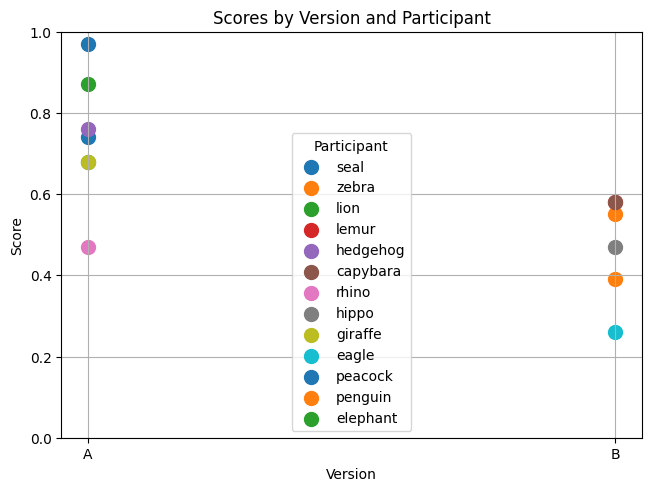

In [4]:
fig, ax = plt.subplots(layout='constrained')

# Loop through each participant and plot their scores
for participant in df_f['id'].unique():
    # Filter the DataFrame for the current participant
    participant_data = df_f[df_f['id'] == participant]
    
    # Plot the scores for this participant
    plt.scatter(participant_data['version'], participant_data['score'], label=participant, s=100)

# Add labels and title
ax.set_title('Scores by Version and Participant')
ax.set_xlabel('Version')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)

# Show legend to differentiate participants
plt.legend(title='Participant')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [58]:
df = pd.read_csv(f"out/study/combined4.csv")
df = df[(df["id"] != "rhino") & (df.pilot == 0) & (df["questionType"].notnull())]
df["reasonCorr"] = df.apply(lambda row: 3 if row["reasonCorrect"] == "right" and row["score"] == 3 else 1 if row["reasonCorrect"] == "right" else 0, axis=1)

dff = df[df["score"]-df["reasonCorr"] != 0]
dff = dff.drop(index=[136, 227, 216, 236, 521])
dff.drop(columns=["cues", "steps", "pilot", "time_elapsed"])

,id,question,version,proof,score,order,questionText,reasoning,reasonCorrect,understanding,misconception,questionType,reasonCorr
96,zebra,qID-11,B,S2_IN1,1.0,8,Is there a mistake? [11],there's an issue with the proof with step 6 us...,wrong,geometric,NaN,1.0,0
122,lion,qID-3,A,S1_IN3,1.0,2,conclude KN congruent to ML? [3],"if quad, then there must be 2 pairs of equal s...",wrong,geometric,quad != rectangle,4.0,0
144,lion,qID-11,A,S2_IN1,1.0,8,Is there a mistake? [11],"know that information is missing, thinks angle...",wrong,geometric,trying to solve for the wrong triangles,1.0,0
171,lemur,qID-2,B,S1_C1,1.0,2,enough info...Vertical Angles Theorem (step 4)...,wasn't sure,NaN,guess,didn't know that intersecting vert angles coul...,5.0,0
189,lemur,qID-11,B,S2_IN2,1.0,7,Is there a mistake? [11],"thought not enough info to use SAS, but was ve...",wrong,"geometric, guess",NaN,1.0,0
193,lemur,qID-2,B,S2_IN2,1.0,7,conclude <MYZ congruent to <MWX? [2],bc triangles aren't congruent the angles canno...,wrong,geometric,NaN,4.0,0
244,hedgehog,qID-11,A,S2_IN1,1.0,7,Is there a mistake? [11],"yes, bc missing requirement for triangle congr...",wrong,geometric,NaN,1.0,0
249,hedgehog,qID-11,A,S2_IN2,1.0,8,Is there a mistake? [11],"yes, bc missing requirement for step 8",wrong,"geometric, direct lookup",NaN,1.0,0
361,hippo,qID-11,B,S1_IN2,1.0,1,Is there a mistake? [11],thought the issue was AAS should be SSS,wrong,geometric,used some information that wasn't in the proof...,1.0,0
371,hippo,qID-11,B,S1_IN1,1.0,3,Is there a mistake? [11],CPCTC is claiming the wrong angles are congrue...,wrong,geometric,convinced that SAS was correctly applied and t...,1.0,0


In [51]:
df = pd.read_csv(f"out/study/combined4.csv")
df = df[(df["id"] != "rhino") & (df.pilot == 0) & (df["questionType"].notnull())]
df_a = df[(df.version == "A")]
df_b = df[(df.version == "B")]
df["reasonCorr"] = df.apply(lambda row: 1 if row["reasonCorrect"] == "right" else 0, axis=1)

In [35]:
# calculate average score for each question type for a student

# Create a new DataFrame for rows where questionType == 1 and score == 3
# (student correctly answered that there is NO MISTAKE in a CORRECT proof)
special_rows = df[(df['questionType'] == 1) & (df['score'] == 3)].copy()

# Distribute the score across questionType 1, 2, and 3
distributed_rows = pd.concat([
    special_rows.assign(score=special_rows['score'] / 3, questionType=1),
    special_rows.assign(score=special_rows['score'] / 3, questionType=2),
    special_rows.assign(score=special_rows['score'] / 3, questionType=3)
])

# Remove the original rows where questionType == 1 and score == 3 from the main DataFrame
df = df[~((df['questionType'] == 1) & (df['score'] == 3))]

# Append the distributed rows to the main DataFrame
df = pd.concat([df, distributed_rows])

# Now group by 'id' and 'questionType', summing up the scores and copying the version
qscores = df.groupby(['id', 'questionType']).agg(
    points=('score', 'sum'),
    version=('version', 'first'), # Assuming 'version' is consistent for each 'id'
    time=('time_elapsed', 'mean'),
    reason=('reasonCorr', 'sum')
).reset_index()

total_scores = {1: 8, 2: 8, 3: 8, 4: 7, 5: 7}
qscores['score'] = qscores.apply(lambda row: row['points'] / total_scores[row["questionType"]], axis=1)
qscores['reasoning'] = qscores.apply(lambda row: row['reason'] / total_scores[row["questionType"]], axis=1)
qscores = qscores.merge(df_f[['id', 'pretest']], on='id', how='left')
qscores.to_csv("out/study/questionTypeDataWithReasons2.csv")
qscores[qscores["score"]-qscores["reasoning"] != 0].head(70)

,id,questionType,points,version,time,reason,score,reasoning,pretest
10,elephant,1.0,7.0,A,12.489625,6,0.875000,0.750000,1.00
11,elephant,2.0,6.0,A,20.908875,5,0.750000,0.625000,1.00
12,elephant,3.0,6.0,A,41.688875,5,0.750000,0.625000,1.00
14,elephant,5.0,7.0,A,59.842857,6,1.000000,0.857143,1.00
20,hedgehog,1.0,8.0,A,25.692875,5,1.000000,0.625000,0.79
21,hedgehog,2.0,6.0,A,11.445625,3,0.750000,0.375000,0.79
22,hedgehog,3.0,4.0,A,27.068500,3,0.500000,0.375000,0.79
25,hippo,1.0,3.0,B,51.188625,1,0.375000,0.125000,0.79
30,lemur,1.0,5.0,B,39.784625,4,0.625000,0.500000,0.71
33,lemur,4.0,5.0,B,26.487286,4,0.714286,0.571429,0.71


In [41]:
# Now group by 'id' and 'questionType', summing up the scores and copying the version
qdf = df.groupby(['id']).agg(
    points=('score', 'sum'),
    version=('version', 'first'), # Assuming 'version' is consistent for each 'id'
    time=('time_elapsed', 'mean'),
    reason=('reasonCorr', 'sum')
).reset_index()

total_scores = {1: 8, 2: 8, 3: 8, 4: 7, 5: 7}
qdf['score'] = qdf.apply(lambda row: row['points'] / 38, axis=1)
qdf['reasoning'] = qdf.apply(lambda row: row['reason'] / 38, axis=1)

# qscores[qscores["score"]-qscores["reasoning"] != 0].head(70)

# qdf = qscores.groupby(['id']).agg(
#     points=('score', 'mean'),
#     # pointssd=('score', 'std'),
#     # time=('time', 'mean'),
#     # timesd=('time', 'std'),
#     reason=('reasoning', 'mean')
# ).reset_index()
qdf.to_csv("out/study/questionTypeReason1RowEach.csv")
qdf

,id,points,version,time,reason,score,reasoning
0,capybara,22.0,B,27.467800,22,0.578947,0.578947
1,eagle,10.0,B,26.475923,10,0.263158,0.263158
2,elephant,33.0,A,31.296211,29,0.868421,0.763158
3,giraffe,26.0,A,19.643806,26,0.684211,0.684211
4,hedgehog,29.0,A,20.280632,22,0.763158,0.578947
5,hippo,18.0,B,35.598188,16,0.473684,0.421053
6,lemur,22.0,B,36.796088,19,0.578947,0.500000
7,lion,26.0,A,33.072219,21,0.684211,0.552632
8,peacock,37.0,A,19.366553,33,0.973684,0.868421
9,penguin,15.0,B,25.231033,14,0.394737,0.368421


In [30]:
df = pd.read_csv("out/study/combined4.csv")
# Check times where student got question right with the wrong reason
df = df[(df["pilot"] == 0) & (~df["proof"].str.startswith("P")) & (~df["reasonCorrect"].isnull())]
df['reason'] = df.apply(lambda row: 1 if row['reasonCorrect'] == "right" else 0, axis=1)

df.to_csv("out/study/per_questionReasons.csv")
select = df[(df["score"] > 0) & (df["reason"] == 0) & (df["question"] != "qID-0")]
select

,id,question,version,time_elapsed,proof,score,pilot,order,questionText,reasoning,cues,steps,reasonCorrect,understanding,misconception,questionType,reason
96,zebra,qID-11,B,1.875,S2_IN1,1.0,0,8,Is there a mistake? [11],there's an issue with the proof with step 6 us...,"construction, all proof text",NaN,wrong,geometric,NaN,1.0,0
122,lion,qID-3,A,30.348,S1_IN3,1.0,0,2,conclude KN congruent to ML? [3],"if quad, then there must be 2 pairs of equal s...","construction, reason definition",step 4,wrong,geometric,quad != rectangle,4.0,0
144,lion,qID-11,A,116.827,S2_IN1,1.0,0,8,Is there a mistake? [11],"know that information is missing, thinks angle...","inconsistency, construction, all proof text",step 8,wrong,geometric,trying to solve for the wrong triangles,1.0,0
189,lemur,qID-11,B,31.705,S2_IN2,1.0,0,7,Is there a mistake? [11],"thought not enough info to use SAS, but was ve...","reason definition, construction, all proof text",NaN,wrong,"geometric, guess",NaN,1.0,0
193,lemur,qID-2,B,11.198,S2_IN2,1.0,0,7,conclude <MYZ congruent to <MWX? [2],bc triangles aren't congruent the angles canno...,"earlier proof steps (text), construction",NaN,wrong,geometric,NaN,4.0,0
244,hedgehog,qID-11,A,1.485,S2_IN1,1.0,0,7,Is there a mistake? [11],"yes, bc missing requirement for triangle congr...","construction, tick marks, all proof text",step 7,wrong,geometric,NaN,1.0,0
249,hedgehog,qID-11,A,41.682,S2_IN2,1.0,0,8,Is there a mistake? [11],"yes, bc missing requirement for step 8","reason definition, inconsistency, construction...","step 7, step 8",wrong,"geometric, direct lookup",NaN,1.0,0
318,rhino,qID-11,A,3.631,S1_IN2,1.0,0,2,Is there a mistake? [11],"saw red inconsistency at step 5, still isn't s...","inconsistency, relies on","step 5, step 3, step 4",wrong,direct lookup,assumed that the problem was with reflexive pr...,1.0,0
324,rhino,qID-11,A,13.321,S1_C2,3.0,0,3,Is there a mistake? [11],"no, no reasoning",NaN,step 9,wrong,guess,post-hoc said they didn't know how to find a m...,1.0,0
325,rhino,qID-3,A,72.860,S1_C2,1.0,0,3,enough info...Congruent Adjacent Angles at ste...,"yes, thinks that congruent adjacent angles nee...",NaN,step 5,wrong,geometric,thinks that adj-angles needs to be based on co...,5.0,0


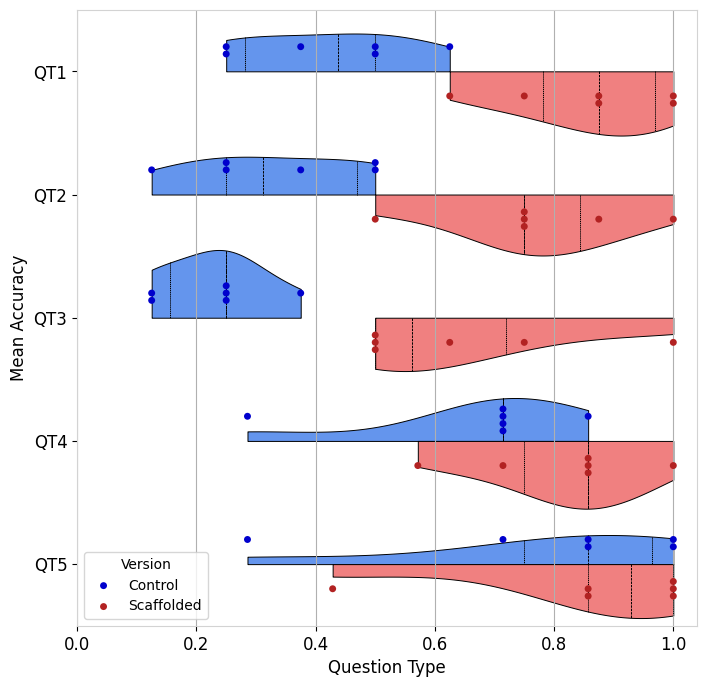

In [411]:
df = pd.read_csv("out/study/questionTypeDataWithReasons2.csv")
df["version"] = df["version"].replace("B", "Control")
df["version"] = df["version"].replace("A", "Scaffolded")
df["questionType"] = df['questionType'].astype(str)
df["questionType"] = df['questionType'].apply(lambda x: f"QT{x.strip('.0')}")

fig, ax = plt.subplots(figsize=(8, 8))

ax.grid('on')
ax.xaxis.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.5)

sns.swarmplot(data=df, x="score", y="questionType", hue="version", palette={"Control": "mediumblue", "Scaffolded": "firebrick"}, dodge=True)

# Left half for version C
g = sns.violinplot(
    x="score", 
    y="questionType", 
    hue="version",
    data=df,
    split=True,
    width=1.1,
    linewidth=.7,
    gridsize=1000,
    cut=0,
    saturation=1,
    palette={"Control": "cornflowerblue", "Scaffolded": "lightcoral"},
    inner="quart",
    linecolor="black",
    ax=ax
)
ax.set_xlabel('Question Type', fontsize=12) 
ax.set_ylabel('Mean Accuracy', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([0, 1.04])
ax.legend(title="Version", labels=["Control", "Scaffolded"], fancybox=True, borderpad=0)
sns.move_legend(ax, "lower left")
fig = g.get_figure()
fig.savefig("plots/questionTypeViolin2.pdf", bbox_inches='tight') 

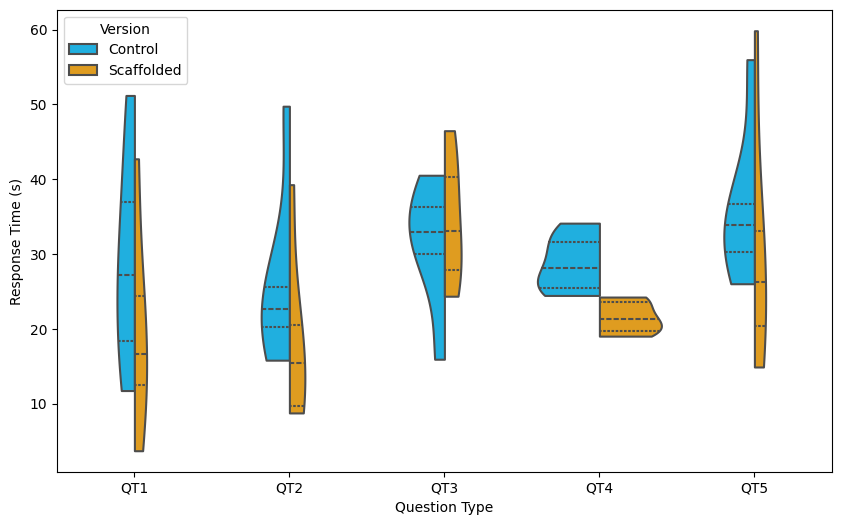

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.violinplot(
    x="questionType", 
    y="time", 
    hue="version",
    data=df,
    split=True,
    linewidth=1.5,
    cut=0,
    palette={"Control": "deepskyblue", "Scaffolded": "orange"},
    inner="quart",
    ax=ax
)
ax.set(xlabel='Question Type', ylabel='Response Time (s)')
ax.legend(title="Version")
sns.move_legend(ax, "upper left")
fig = g.get_figure()
fig.savefig("plots/responseTimeViolin.png", bbox_inches='tight') 

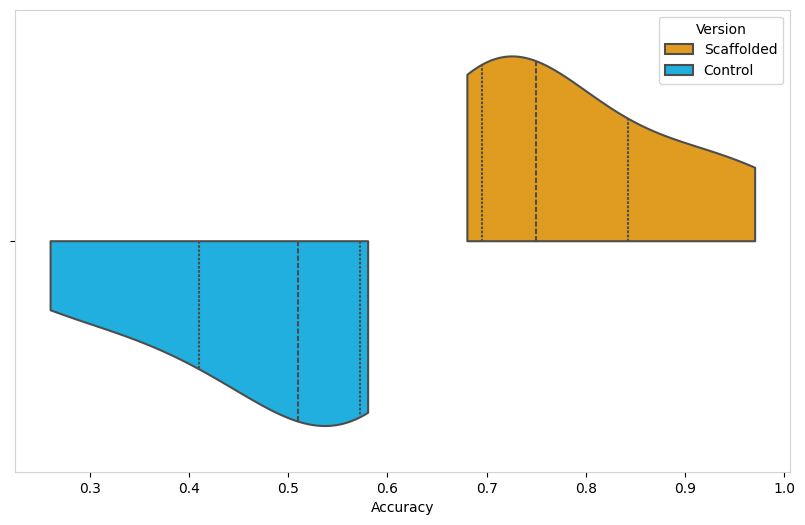

In [137]:
df = pd.read_csv(f"out/study/scores.csv")
fig, ax = plt.subplots(figsize=(10, 6))
df = df[(df.pilot == 0) & (df.id != "rhino")]
df["version"] = df["version"].replace("B", "Control")
df["version"] = df["version"].replace("A", "Scaffolded")

g = sns.violinplot(
    x="score", 
    hue="version",
    data=df,
    split=True,
    linewidth=1.5,
    palette={"Control": "deepskyblue", "Scaffolded": "orange"},
    cut=0,
    inner="quart",
    ax=ax
)
ax.set(xlabel='Accuracy')
ax.legend(title="Version")
fig = g.get_figure() 
# fig.savefig("plots/scoreViolin2.png", bbox_inches='tight') 

In [403]:
df = pd.read_csv(f"out/study/scores.csv")
df = df[(df.pilot == 0) & (df.id != "rhino")]
df["version"] = df["version"].replace("B", "Control")
df["version"] = df["version"].replace("A", "Scaffolded")

x1 = df[df["version"] == "Control"]["score"].to_numpy()
x2 = df[df["version"] == "Scaffolded"]["score"].to_numpy()
data_x = [x1,x2]
data_x

[array([0.55, 0.58, 0.58, 0.47, 0.26, 0.39]),
 array([0.74, 0.68, 0.76, 0.68, 0.97, 0.87])]

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1] [1 1]


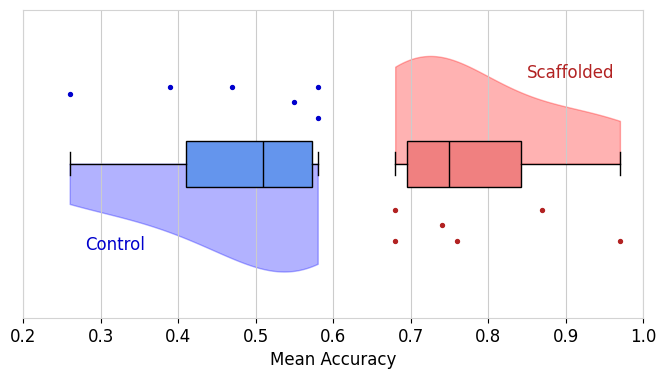

In [407]:
plt.rc('axes',edgecolor='lightgray')
colors=['cornflowerblue', 'lightcoral']
violinclrs = ['blue', 'red']
scatter_colors = ['mediumblue', 'firebrick']
jitter = [[-0, .05, -.05, .05, .025, .05], [0, -.05, -.05, .05, -.05, .05]]
fig, ax = plt.subplots(figsize=(8, 4))

# Show the major grid and style it slightly.
ax.grid(which='major', color='#CCCCCC', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
# ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.5)
# Make the minor ticks and gridlines show.
# ax.minorticks_on()

for idx, x in enumerate(data_x):
    # Boxplot data
    bp = ax.boxplot(x, patch_artist = True, vert = False)
    
    # Change to the desired color and add transparency
    for patch in bp['boxes']:
        patch.set_facecolor(colors[idx])
        patch.set_alpha(1)
    for median in bp['medians']:
        median.set_color('black')
        
    # Violinplot data
    vp = ax.violinplot(x, points=500, widths=.7,
                   showmeans=False, showextrema=False, showmedians=False, vert=False)
    
    b = vp["bodies"][0]
    b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx % 2, idx % 2 + 1)
        # Change to the desired color
    b.set_color(violinclrs[idx])
    
    # Scatterplot data
    # Add jitter effect so the features do not overlap on the y-axis
    y = np.zeros(6) + 1.2 - ((idx % 2) * .4) + jitter[idx]
    plt.scatter(x, y, s=8, c=scatter_colors[idx])
ax.tick_params(axis='both', which='major', labelsize=12)
# plt.yticks(np.arange(1,3,1), ['C', 'S'])  # Set text labels.
print(ax.xaxis.get_majorticklocs(), ax.yaxis.get_majorticklocs())
ax.set_xlim([0.2,1])
ax.annotate('Control', xy=(.4, .85), xytext=(.28, 0.72), color="mediumblue", size=12)
ax.annotate('Scaffolded', xy=(.83, 1.15), xytext=(.85, 1.28), color="firebrick", size=12)
plt.xlabel('Mean Accuracy', fontsize=12)
ax.get_yaxis().set_ticks([])
# ax.spines['right'].set_visible(False)
plt.show()
fig = ax.get_figure()
fig.savefig("accuracy.pdf", bbox_inches="tight", pad_inches=0.05)

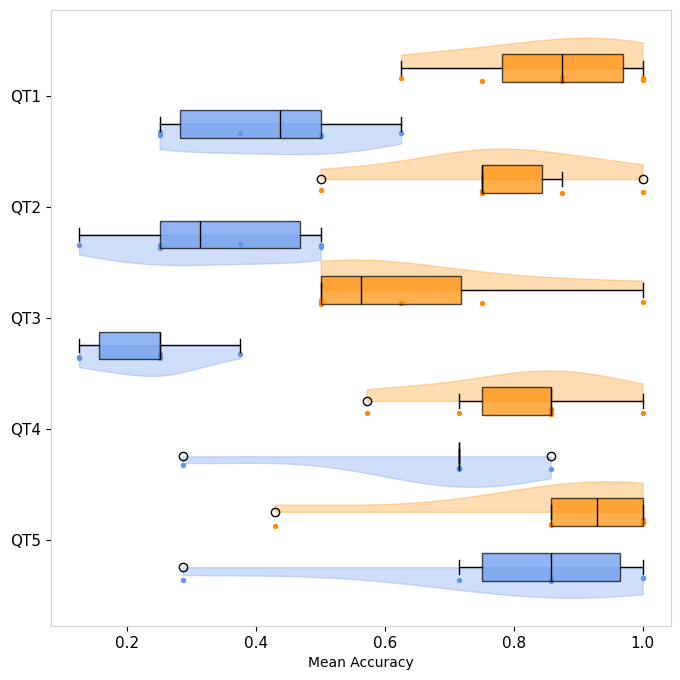

In [224]:
plt.rc('axes',edgecolor='lightgray')
fig, ax = plt.subplots(figsize=(8, 8))

# Boxplot data
bp = ax.boxplot(data_x, patch_artist = True, vert = False)

# Change to the desired color and add transparency
for idx, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colors[idx % 2])
    patch.set_alpha(0.7)
for median in bp['medians']:
    median.set_color('black')
    
# Violinplot data
vp = ax.violinplot(data_x, points=500, widths=1.1,
               showmeans=False, showextrema=False, showmedians=False, vert=False)

for idx, b in enumerate(vp['bodies']):
    b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx + (idx % 2), (idx+1) + (idx % 2))
    # Change to the desired color
    b.set_color(colors[idx % 2])

jitter = [[-0, .05, -.05, .05, .025, .05], [0, -.05, -.05, .05, -.05, .05]]
# Scatterplot data
for idx, features in enumerate(data_x):
    # Add jitter effect so the features do not overlap on the y-axis
    y = np.full(len(features), idx + .8)
    idxs = np.arange(len(y))
    out = y.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
    y = out
    plt.scatter(features, y, s=8, c=scatter_colors[idx % 2])
ax.tick_params(axis='both', which='major', labelsize=11)
plt.yticks(np.arange(1.5,11.5,2), tlabels)  # Set text labels.
plt.xlabel('Mean Accuracy')
plt.show()
fig = ax.get_figure()
fig.savefig("questiontypeclipped.pdf", bbox_inches="tight", pad_inches=0.05)

In [316]:
df = pd.read_csv("out/study/questionTypeDataWithReasons2.csv")
df["version"] = df["version"].replace("B", "Control")
df["version"] = df["version"].replace("A", "Scaffolded")
df["questionType"] = df['questionType'].astype(str)
df["questionType"] = df['questionType'].apply(lambda x: f"QT{x.strip('.0')}")

cs, ss, tlabels = [], [], []
for qt in [5, 4, 3, 2, 1]:
    dfq = df[df["questionType"]==f"QT{qt}"]
    tlabels.append(f"QT{qt}")
    cs.append(dfq[dfq["version"] == "Control"]["score"].to_numpy())
    ss.append(dfq[dfq["version"] == "Scaffolded"]["score"].to_numpy())
datas = [cs, ss]
df[(df["version"] == "Control") & (df["questionType"]=="QT4")]

,Unnamed: 0,id,questionType,points,version,time,reason,score,reasoning,pretest
3,3,capybara,QT4,5.0,Control,34.117143,5,0.714286,0.714286,0.79
8,8,eagle,QT4,2.0,Control,25.144143,2,0.285714,0.285714,0.86
28,28,hippo,QT4,5.0,Control,29.710286,5,0.714286,0.714286,0.79
33,33,lemur,QT4,5.0,Control,26.487286,4,0.714286,0.571429,0.71
48,48,penguin,QT4,6.0,Control,32.203857,6,0.857143,0.857143,0.79
58,58,zebra,QT4,5.0,Control,24.452286,5,0.714286,0.714286,0.93


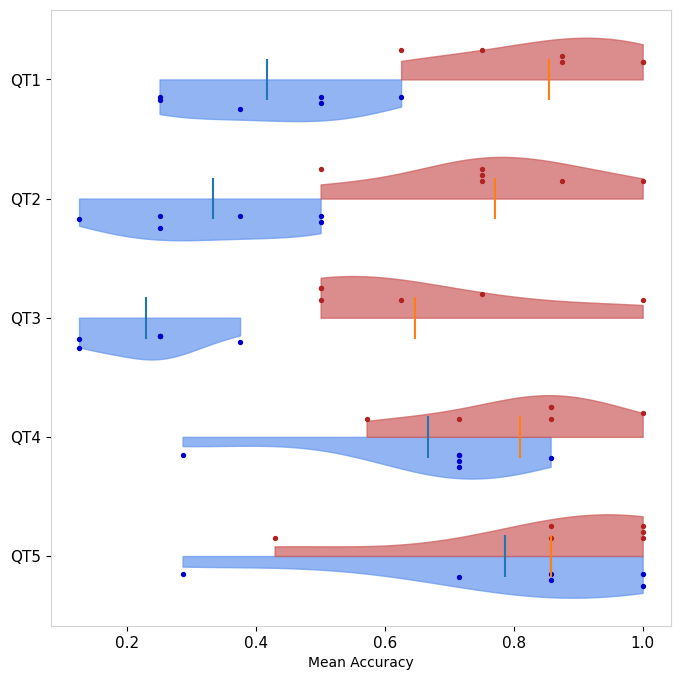

In [318]:
fig, ax = plt.subplots(figsize=(8, 8))

for idx, data_x in enumerate(datas):
   # Boxplot data
    # bp = ax.boxplot(data_x, patch_artist = True, vert = False, widths=[.2 for x in range(len(data_x))])
    
    # Change to the desired color and add transparency
    # for patch in bp['boxes']:
    #     patch.set_facecolor(colors[idx])
    #     patch.set_alpha(0.7)
    # for median in bp['medians']:
    #     median.set_color('black')

    # Violinplot data
    vp = ax.violinplot(data_x, points=500, widths=.7,
                   showmeans=True, showextrema=False, showmedians=False, vert=False)

    for i, b in enumerate(vp['bodies']):
        b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], i + (idx % 2), i + (idx % 2 + 1))
            # Change to the desired color
        b.set_color(colors[idx])
        b.set_alpha(.7)
        
    # Scatterplot data
    for i, features in enumerate(data_x):
    #Add jitter effect so the features do not overlap on the y-axis
        y = np.zeros(6) + i + .8 + ((idx % 2) * .4) + jitter[idx]
        plt.scatter(features, y, s=8, c=scatter_colors[idx])
ax.tick_params(axis='both', which='major', labelsize=11)
plt.yticks(np.arange(1,6,1), tlabels)  # Set text labels.
plt.xlabel('Mean Accuracy')
plt.show()
fig = ax.get_figure()
# fig.savefig("questiontypeshared.pdf", bbox_inches="tight", pad_inches=0.05)